## 패키지 가져오기

In [1]:
from pykrx import stock
import pandas_datareader.data as web
from talib import BBANDS, RSI, MACD

import pandas as pd
import numpy as np

import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


In [3]:
# 2023년 3월 1일 기준 KOSPI와 KOSDAQ의 종목 수를 파악
start_date, end_date = "2015-02-11", "2023-03-01"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


## 전략 수립 및 구현

12일을 단기 이동평균, 26일 중기 이동평균으로 사용  
단기 이동평균과 중기 이동평균의 차이를 MACD Signal이라고 하고, MACD Signal의 9일 이동평균선을 사용
만약 MACD가 MACD Signal보다 높으면 매수,낮으면 매도를 실시 함.  
이 때, MACD Signal이 가장 높은 100개(최대)를 매수하고, 가장 낮은 100개(최대)를 매도함  
성과는 연간 -4.7%의 수익률을 기록

In [4]:
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
rebalance_date[:10]

DatetimeIndex(['2015-02-11', '2015-02-12', '2015-02-13', '2015-02-16',
               '2015-02-17', '2015-02-23', '2015-02-24', '2015-02-25',
               '2015-02-26', '2015-02-27'],
              dtype='datetime64[ns]', name='날짜', freq=None)

In [5]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in tqdm(rebalance_date):
    kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
    kosdaq_tickers = stock.get_market_ticker_list(date, market='KOSDAQ')
    all_tickers += kospi_tickers
    all_tickers += kosdaq_tickers
all_tickers = list(set(all_tickers))
print(f"해당 기간동안의 모든 ticker 개수는 {len(all_tickers)}")

100%|██████████| 1981/1981 [15:54<00:00,  2.08it/s]


해당 기간동안의 모든 ticker 개수는 2863


In [6]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('MACD_price_df.csv')

100%|██████████| 2863/2863 [04:47<00:00,  9.96it/s]


In [7]:
price_df = pd.read_csv('MACD_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,182360,035810,221950,218710,016740,000300,332710,400840,102370,007720,...,014915,033310,140890,271980,033630,215090,000320,063170,037330,131090
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-11,6970,5737,0.0,0.0,0.0,1330,0.0,0.0,0.0,1035,...,2265,1639,4565.0,0.0,4125.0,0.0,22300,6090,1905,631
2015-02-12,6820,5627,0.0,0.0,0.0,1285,0.0,0.0,0.0,1095,...,2320,1655,4565.0,0.0,4125.0,0.0,21800,6320,1880,629
2015-02-13,6957,5637,0.0,0.0,0.0,1285,0.0,0.0,0.0,1080,...,2375,1679,4595.0,0.0,4200.0,0.0,21800,6320,1890,656
2015-02-16,7259,5776,0.0,0.0,0.0,1275,0.0,0.0,0.0,1130,...,2355,1759,4595.0,0.0,4200.0,0.0,21800,6760,1935,675
2015-02-17,7296,5677,0.0,0.0,0.0,1290,0.0,0.0,0.0,1085,...,2390,1774,4595.0,0.0,4400.0,0.0,21900,6880,1945,684


In [8]:
fastperiod = 12
slowperiod = 26
signalperiod = 5

macd_df = price_df.copy()
macd_signal_df = price_df.copy()
macd_hist_df = price_df.copy()

for col in price_df.columns:
    macd_df,macd_signal, macd_hist = MACD(price_df[col], fastperiod=fastperiod, 
                                       slowperiod=slowperiod, signalperiod=signalperiod)
    macd_df[col], macd_signal_df[col], macd_hist_df[col] = macd_df, macd_signal, macd_hist

In [9]:
macd_signal_df = macd_signal_df.fillna(0)
def calculate_weights(macd_signal_df, long=100, short=100):
    long_signal = ((macd_signal_df
                  .where(macd_signal_df > 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    short_signal = ((macd_signal_df
                   .where(macd_signal_df < 0)
                   .rank(axis=1, ascending=True) <= short)
                    .astype(int)
                    .mul(-1))
    signal = long_signal.add(short_signal)
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        short_signal = (arr == -1).astype(int)
        long_cnt = np.clip(np.sum((arr == 1)), 0, long)
        short_cnt = np.clip(np.sum((arr == -1)), 0, short)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        if short_cnt > 0:
            short_signal = -1 * short_signal / short_cnt
        return long_signal.add(short_signal)
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(macd_signal_df)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [10]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,182360,035810,221950,218710,016740,000300,332710,400840,102370,007720,...,014915,033310,140890,271980,033630,215090,000320,063170,037330,131090
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,-0.004710,0.005051,0.0,0.0,0.008961,-0.036836,0.0,-0.002427,0.021382,-0.006562,...,0.020930,-0.008282,0.0,-0.002026,0.0,0.0,0.001965,0.022883,0.001616,0.011464
2023-02-23,-0.018402,-0.021776,0.0,0.0,-0.012433,-0.022497,0.0,0.002433,-0.022544,-0.013210,...,-0.033030,-0.025052,0.0,-0.006091,0.0,0.0,-0.002941,0.013423,-0.006455,-0.002616
2023-02-24,-0.003749,-0.029110,0.0,0.0,-0.010791,-0.011507,0.0,0.000000,-0.004942,-0.014726,...,0.024735,-0.036403,0.0,-0.021961,0.0,0.0,-0.001967,0.011038,-0.012453,0.003497
2023-02-27,0.047312,0.010582,0.0,0.0,0.001818,0.005821,0.0,-0.002427,0.019868,0.001359,...,0.000000,0.013333,0.0,0.000522,0.0,0.0,0.000000,-0.008734,0.013158,0.000871
2023-02-28,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [11]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,0.003903
2023-02-22,0.005679
2023-02-23,0.000233


In [12]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,-0.319793
2023-02-22,-0.315930
2023-02-23,-0.315771


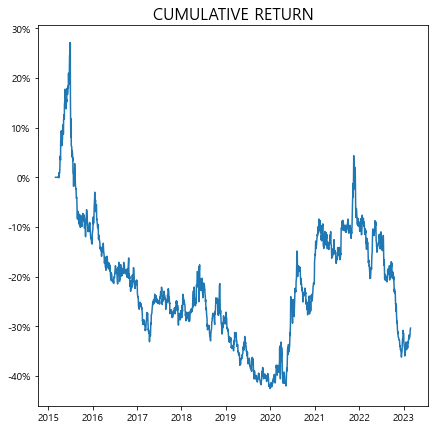

In [13]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## 자세한 결과 분석

In [14]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

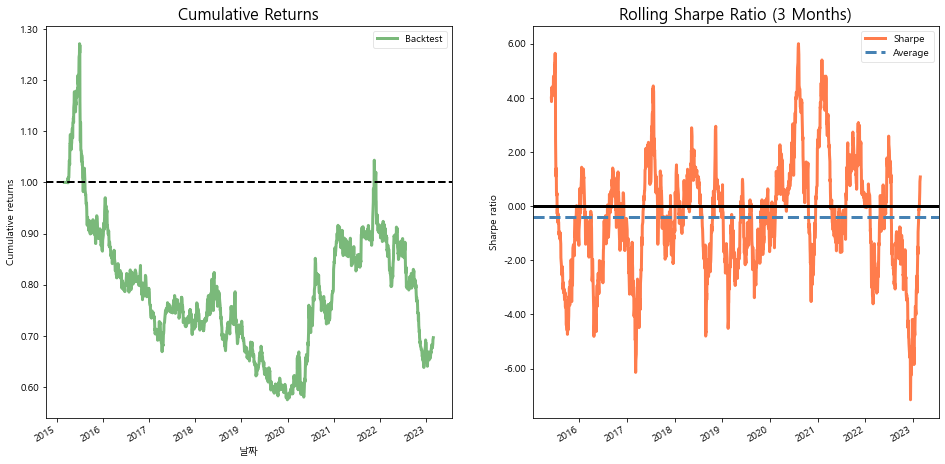

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2015-03-02
End date,2023-02-27
Total months,93
,Backtest
Annual return,-4.523%
Cumulative returns,-30.359%
Annual volatility,17.878%
Sharpe ratio,-0.17
Calmar ratio,-0.08
Stability,0.06
Max drawdown,-54.769%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,54.77,2015-06-30,2019-12-30,NaT,NaN
1,3.35,2015-05-20,2015-05-29,2015-06-04,12
2,2.71,2015-04-21,2015-04-23,2015-04-30,8
3,1.88,2015-06-18,2015-06-23,2015-06-24,5
4,1.72,2015-05-04,2015-05-06,2015-05-08,5


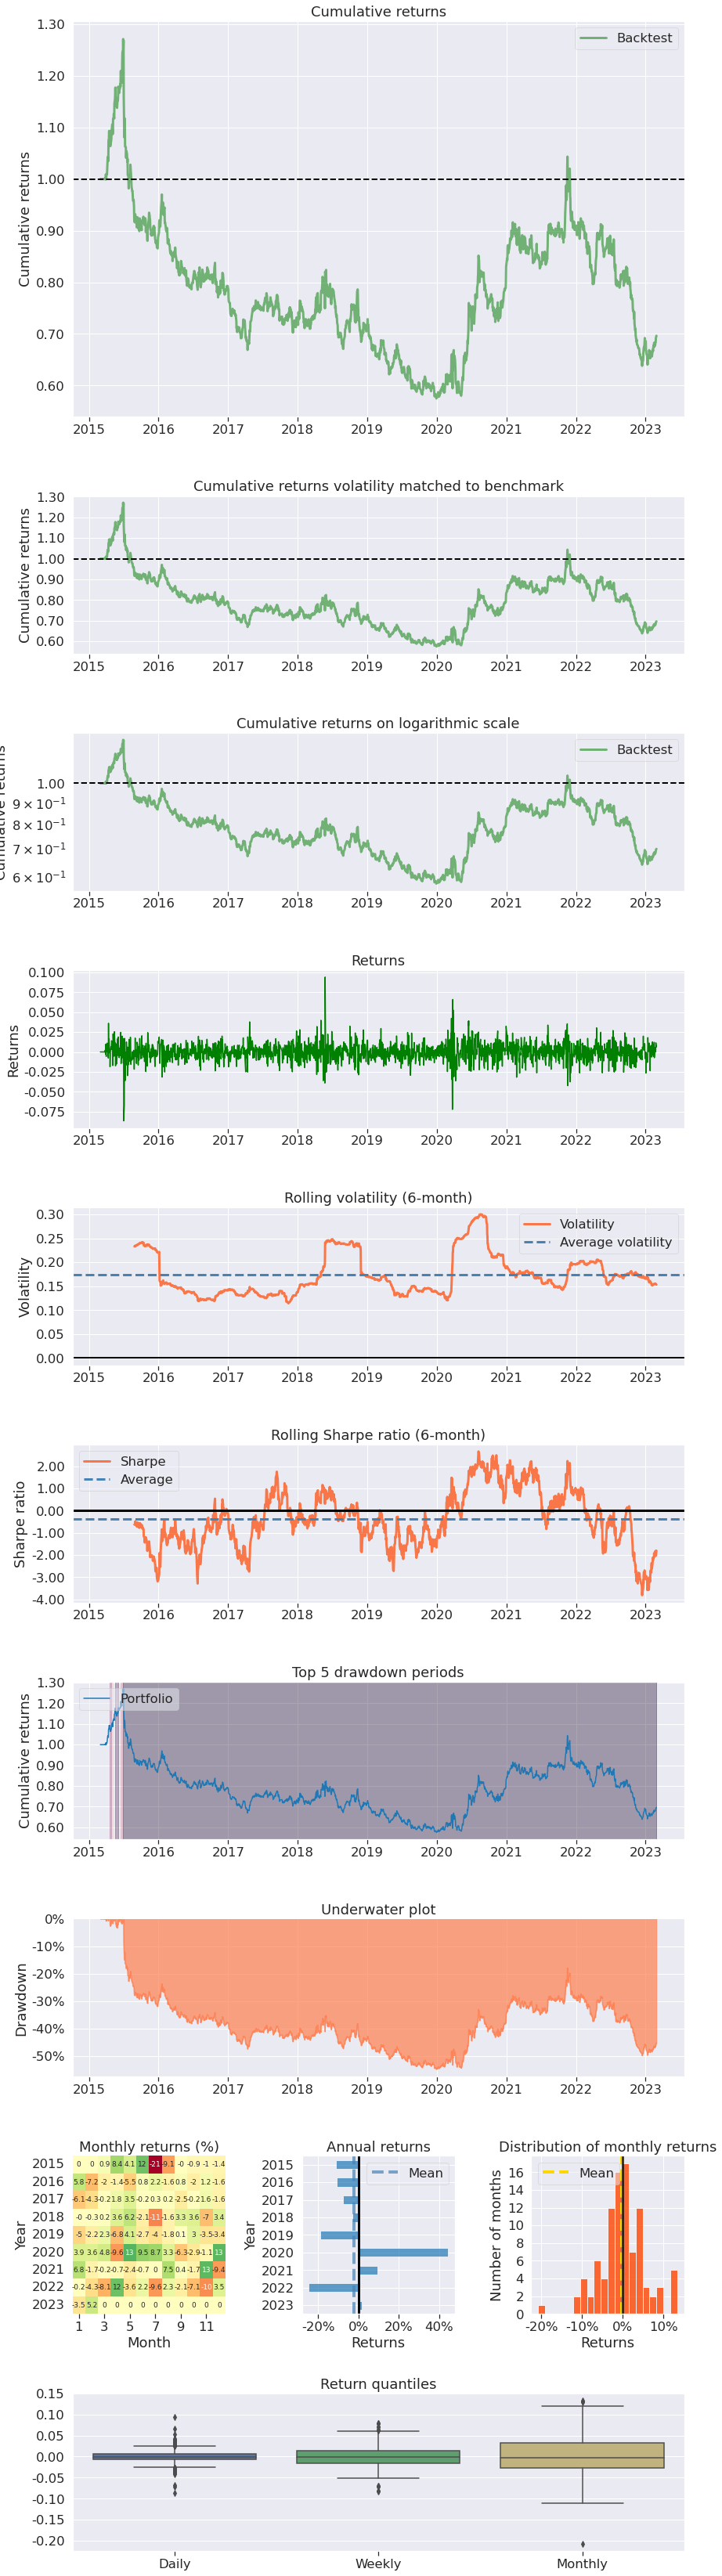

In [16]:
pf.create_returns_tear_sheet(daily_return['daily_return'])

## 전략수정(역으로 해보기)

위의 전략과 반대되는 전략 사용  
MACD Signal이 가장 높은 100개(최대)를 매도하고, 가장 낮은 100개(최대)를 매수함  
성과는 더 안좋음

In [17]:
price_df = pd.read_csv('MACD_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,182360,035810,221950,218710,016740,000300,332710,400840,102370,007720,...,014915,033310,140890,271980,033630,215090,000320,063170,037330,131090
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-11,6970,5737,0.0,0.0,0.0,1330,0.0,0.0,0.0,1035,...,2265,1639,4565.0,0.0,4125.0,0.0,22300,6090,1905,631
2015-02-12,6820,5627,0.0,0.0,0.0,1285,0.0,0.0,0.0,1095,...,2320,1655,4565.0,0.0,4125.0,0.0,21800,6320,1880,629
2015-02-13,6957,5637,0.0,0.0,0.0,1285,0.0,0.0,0.0,1080,...,2375,1679,4595.0,0.0,4200.0,0.0,21800,6320,1890,656
2015-02-16,7259,5776,0.0,0.0,0.0,1275,0.0,0.0,0.0,1130,...,2355,1759,4595.0,0.0,4200.0,0.0,21800,6760,1935,675
2015-02-17,7296,5677,0.0,0.0,0.0,1290,0.0,0.0,0.0,1085,...,2390,1774,4595.0,0.0,4400.0,0.0,21900,6880,1945,684


In [18]:
fastperiod = 12
slowperiod = 26
signalperiod = 5

macd_df = price_df.copy()
macd_signal_df = price_df.copy()
macd_hist_df = price_df.copy()

for col in price_df.columns:
    macd_df,macd_signal, macd_hist = MACD(price_df[col], fastperiod=fastperiod, 
                                       slowperiod=slowperiod, signalperiod=signalperiod)
    macd_df[col], macd_signal_df[col], macd_hist_df[col] = macd, macd_signal, macd_hist

NameError: name 'macd' is not defined

In [ ]:
macd_signal_df = macd_signal_df.fillna(0)
def calculate_weights(macd_signal_df, long=100, short=100):
    long_signal = ((macd_signal_df
                  .where(macd_signal_df < 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    short_signal = ((macd_signal_df
                   .where(macd_signal_df > 0)
                   .rank(axis=1, ascending=True) <= short)
                    .astype(int)
                    .mul(-1))
    signal = long_signal.add(short_signal)
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        short_signal = (arr == -1).astype(int)
        long_cnt = np.clip(np.sum((arr == 1)), 0, long)
        short_cnt = np.clip(np.sum((arr == -1)), 0, short)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        if short_cnt > 0:
            short_signal = -1 * short_signal / short_cnt
        return long_signal.add(short_signal)
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(macd_signal_df)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [ ]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

In [ ]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

In [ ]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))